<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/kaggle_license_plate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](attachment:image.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

## Preparation of the data

Import libraries

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We display the files in Kaggle repertoire :

In [ ]:
IMAGE_SIZE = 224
DATA_ROOT = "./drive/MyDrive/data"

In [ ]:
import os
for dirname, _, filenames in os.walk(DATA_ROOT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./drive/MyDrive/data/car-plate-detection/images/Cars122.png
./drive/MyDrive/data/car-plate-detection/images/Cars1.png
./drive/MyDrive/data/car-plate-detection/images/Cars120.png
./drive/MyDrive/data/car-plate-detection/images/Cars118.png
./drive/MyDrive/data/car-plate-detection/images/Cars121.png
./drive/MyDrive/data/car-plate-detection/images/Cars105.png
./drive/MyDrive/data/car-plate-detection/images/Cars0.png
./drive/MyDrive/data/car-plate-detection/images/Cars107.png
./drive/MyDrive/data/car-plate-detection/images/Cars108.png
./drive/MyDrive/data/car-plate-detection/images/Cars10.png
./drive/MyDrive/data/car-plate-detection/images/Cars101.png
./drive/MyDrive/data/car-plate-detection/images/Cars114.png
./drive/MyDrive/data/car-plate-detection/images/Cars126.png
./drive/MyDrive/data/car-plate-detection/images/Cars132.png
./drive/MyDrive/data/car-plate-detection/images/Cars124.png
./drive/MyDrive/data/car-plate-detection/images/Cars13.png
./drive/MyDrive/data/car-plate-detection/image

We create the variable X containing all the images of cars by resizing them.



In [ ]:
img_dir = DATA_ROOT + "/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [ ]:
DATA_ROOT

'./drive/MyDrive/data'

In [ ]:
# path = '../input/car-plate-detection/annotations'
# text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]

path = DATA_ROOT + '/car-plate-detection/annotations'
text_files = [DATA_ROOT + '/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]

y=[]
for i in text_files:
    print(i)
    y.append(resizeannotation(i))

./drive/MyDrive/data/car-plate-detection/annotations/Cars0.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars1.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars10.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars100.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars101.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars102.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars103.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars104.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars105.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars106.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars107.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars108.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars109.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars11.xml
./drive/MyDrive/data/car-plate-detection/annotations/Cars110.xml
./drive/MyDrive/data/car-plate-

In [ ]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [ ]:
np.array(X).shape

(433, 224, 224, 3)

In [ ]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset : 

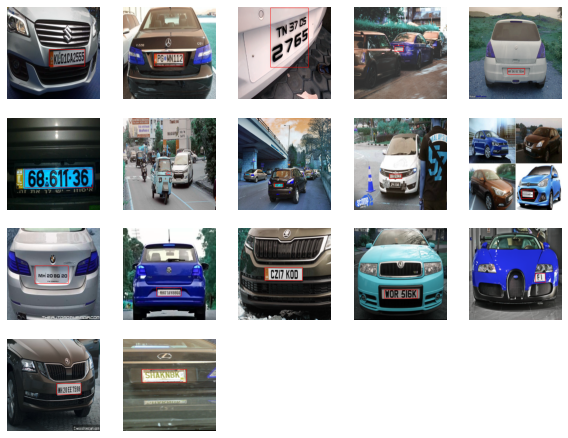

In [ ]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    image = cv2.rectangle(X[i],(y[i][0],y[i][1]),(y[i][2],y[i][3]),(255, 0, 0))
    plt.imshow(image)

We can draw the rectangle containing the license plate using the OpenCV library

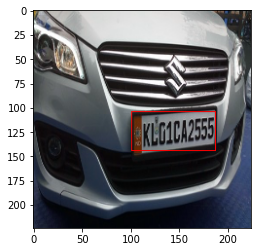

In [ ]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(255, 0, 0))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [ ]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [ ]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [ ]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [ ]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
Non-

In [ ]:
import datetime
import tensorflow as tf

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train = model.fit(X_train, y_train,
#                   validation_data=(X_val, y_val),
#                   epochs=50, batch_size=32, verbose=1)


train = model.fit(x=X_train, y=y_train,
                  validation_data=(X_val, y_val),
                  epochs=50, batch_size=32, verbose=1,
                  callbacks=[tensorboard_callback])

Epoch 1/50
10/10 [==============================] - 23s 392ms/step - loss: 0.1166 - accuracy: 0.5675 - val_loss: 0.0884 - val_accuracy: 0.4571
Epoch 2/50
10/10 [==============================] - 1s 56ms/step - loss: 0.0932 - accuracy: 0.5613 - val_loss: 0.0896 - val_accuracy: 0.4571
Epoch 3/50
10/10 [==============================] - 1s 55ms/step - loss: 0.0842 - accuracy: 0.5563 - val_loss: 0.0834 - val_accuracy: 0.4571
Epoch 4/50
10/10 [==============================] - 1s 53ms/step - loss: 0.0851 - accuracy: 0.5767 - val_loss: 0.0830 - val_accuracy: 0.4571
Epoch 5/50
10/10 [==============================] - 1s 55ms/step - loss: 0.0806 - accuracy: 0.5571 - val_loss: 0.0831 - val_accuracy: 0.4571
Epoch 6/50
10/10 [==============================] - 1s 55ms/step - loss: 0.0785 - accuracy: 0.5405 - val_loss: 0.0833 - val_accuracy: 0.4571
Epoch 7/50
10/10 [==============================] - 1s 56ms/step - loss: 0.0801 - accuracy: 0.5488 - val_loss: 0.0828 - val_accuracy: 0.4571
Epoch 8/50


In [ ]:
model.save('my_model.h5', overwrite=True) 

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 89.66%


In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

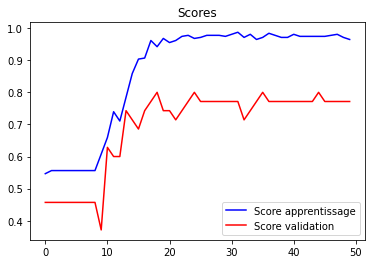

In [ ]:
plot_scores(train)

## DETECTION 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


100/100 [==============================] - 1s 4ms/step - loss: 0.0060 - accuracy: 0.8966
Test results 
 Loss: 0.005973448045551777 
 Accuracy 0.8965517282485962


In [ ]:
 y_cnn = model.predict(X_test)

We can see how our model localize license plates on our testing set :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

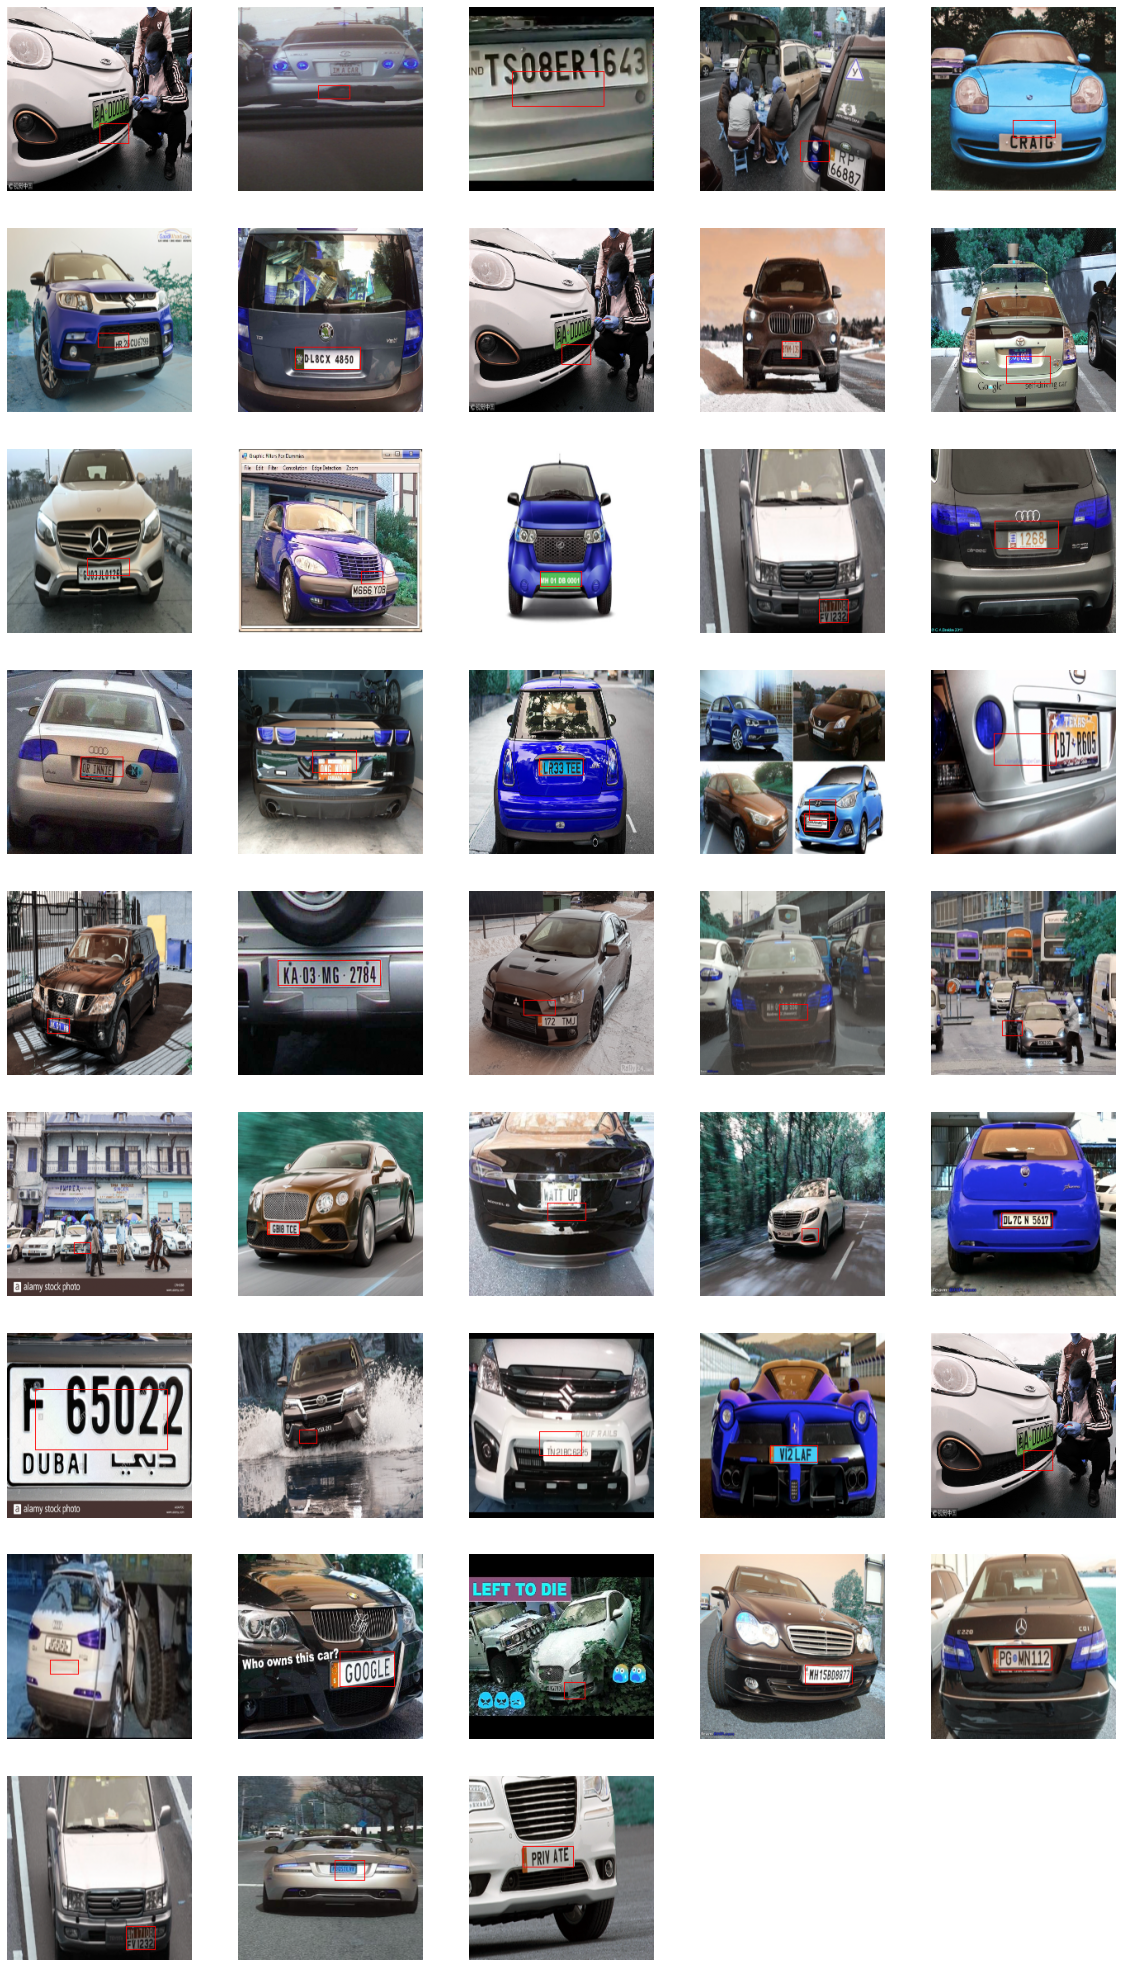

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(255, 0, 0))
    plt.imshow(image)

